# Machine Learning Project

### Libraries

In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import time
from sklearn import metrics

import warnings; warnings.simplefilter('ignore')

#### Global variables

In [440]:
random_seed = 42
epsilon = 0.001

### Importing data

In [3]:
train = pd.read_csv('SPECTF_test.txt', header= None)
test = pd.read_csv('SPECTF_train.txt', header= None)
train = np.array(train)
test = np.array(test)

#### Checking nulls

In [8]:
True in np.isnan(train)

False

In [9]:
True in np.isnan(test)

False

#### Dataset description

In [11]:
print ("Train Lenght:: ", len(train))
print ("Test Lenght:: ", len(test))

print ("Train Shape:: ", train.shape)
print ("Test Shape:: ", test.shape)

Train Lenght::  187
Test Lenght::  80
Train Shape::  (187, 45)
Test Shape::  (80, 45)


#### Plot of Class Label

##### Training

1    172
0     15
Name: 0, dtype: int64


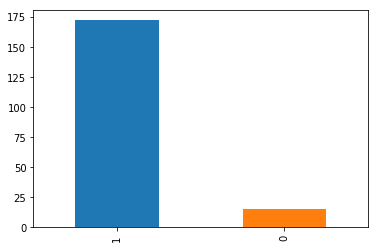

In [15]:
train_plot = pd.DataFrame(train)
print(train_plot[0].value_counts())
train_plot[0].value_counts().plot.bar()

##### Test

1    40
0    40
Name: 0, dtype: int64


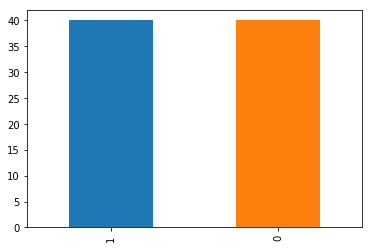

In [16]:
test_plot = pd.DataFrame(test)
print(test_plot[0].value_counts())
test_plot[0].value_counts().plot.bar()

## Train and test sets

### Original

#### Separating train and test set for class

In [4]:
x_trainOriginal = train[:,1:]
y_trainOriginal = train[:,0]

x_testOriginal = test[:,1:]
y_testOriginal = test[:,0]

### Merged train and test (70/30)

In [17]:
merged = np.concatenate((train, test), axis = 0)
x_trainMerged, x_testMerged, y_trainMerged, y_testMerged = train_test_split(merged[:,1:], merged[:,0], test_size=0.2996, random_state = random_seed)

#### Training

1    149
0     38
Name: 0, dtype: int64


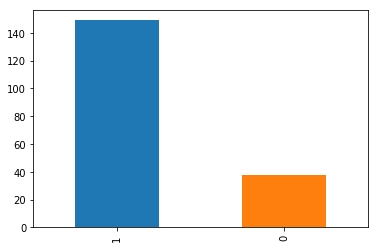

In [18]:
y_trainMergedPlot = pd.DataFrame(y_trainMerged)
print(y_trainMergedPlot[0].value_counts())
y_trainMergedPlot[0].value_counts().plot.bar()

#### Test

1    63
0    17
Name: 0, dtype: int64


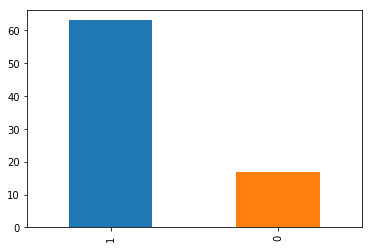

In [19]:
y_testMergedPlot = pd.DataFrame(y_testMerged)
print(y_testMergedPlot[0].value_counts())
y_testMergedPlot[0].value_counts().plot.bar()

# Support Vector Machine

## Classification Function

In [598]:
def classify(x,w):
    x=np.array(x)
    w=np.array(w)
    
    x = np.column_stack((x, np.ones(len(x))))
    
    y = []
    for i in range(len(x)):
        classify = np.dot(w,x[i]) 
        #print(classify)
        if  classify >= 1:
            y.append(1)
        elif classify <= -1:
            y.append(0)
    return(y)

## Special case for classifier with wTx+b>=0
def classifySpecialCase(x,w):
    x=np.array(x)
    w=np.array(w)
    
    x = np.column_stack((x, np.ones(len(x))))
    
    y = []
    for i in range(len(x)):
        classify = np.dot(w,x[i]) 
        #print(classify)
        if  classify >= 0:
            y.append(1)
        elif classify < 0:
            y.append(0)
    return(y)
    
    
def svmTest(x,w,y):
    correctCount = 0
    predictedValues = classify(x,w)
    #print(predictedValues)
    for ipoint in range(len(x)):
        #print(ipoint, y[ipoint], predictedValues[ipoint])
        if (predictedValues[ipoint]==y[ipoint]):
            correctCount += 1
            
    return(correctCount/len(x))

## Special case for test classifier with wTx+b>=0
def svmTestSpecialCase(x,w,y):
    correctCount = 0
    predictedValues = classifySpecialCase(x,w)
    #print(predictedValues)
    for ipoint in range(len(x)):
        #print(ipoint, y[ipoint], predictedValues[ipoint])
        if (predictedValues[ipoint]==y[ipoint]):
            correctCount += 1
            
    return(correctCount/len(x))

## Functions to Update Gammas

In [254]:
def updateGamma(x,y,w,gamma,epsilon):
    valuePositive = 0
    valueNegative = 0
    for idata in range(len(x)):   
        if(y[idata]==1): ## class 1 is positive class
            valuePositive += 1 - np.dot(w,x[idata])
        else:
            valueNegative += np.dot(w,x[idata]) + 1
    gamma = gamma - epsilon*(valuePositive + valueNegative)
    
    return(gamma)

In [550]:
def updateMultipleGammas(x,y,w,gammas,epsilon):
    gammas=np.array(gammas)
    valuePositive = 0
    valueNegative = 0
    for idata in range(len(x)):   
        if(y[idata]==1): ## class 1 is positive class
            gammas[idata] = gammas[idata] - epsilon*((1-(np.dot(w,x[idata])))+1)
        else:
            gammas[idata] = gammas[idata] - epsilon*((np.dot(w,x[idata])+1)+1)
    return(gammas)

## Support Vector Machine - Traditional

In [547]:
def learnWeights(w0, gamma, x, y, epsilon):
    w0=np.array(w0).astype(float)
    x=np.array(x)
    y=np.array(y)
    
    x = np.column_stack((x, np.ones(len(x))))
        
    gamma = gamma
    epsilon = epsilon
    
    for i in range(len(w0)):
        sumPositiveClass = 0
        sumNegativeClass = 0
        for d in range(len(x)):
            if(y[d]==1):
                sumPositiveClass += x[d][i]
            else:
                sumNegativeClass += x[d][i]
                        
        w0[i] = w0[i] - epsilon*((2*w0[i])-(gamma*sumPositiveClass)+(gamma*sumNegativeClass))
        
    gamma = updateGamma(x,y,w0,gamma,epsilon)
        
    return(gamma,w0)

In [443]:
def learnWeightsGammas(w0, gammas, x, y, epsilon):
    w0=np.array(w0).astype(float)
    x=np.array(x)
    y=np.array(y)
    gammas = np.array(gammas)
    
    x = np.column_stack((x, np.ones(len(x))))
        
    epsilon = epsilon
    
    for i in range(len(w0)):
        sumPositiveClass = 0
        sumNegativeClass = 0
        for d in range(len(x)):
            if(y[d]==1):
                sumPositiveClass += x[d][i]*gammas[d]
            else:
                sumNegativeClass += x[d][i]*gammas[d]
        
        w0[i] = w0[i] - epsilon*(2*w0[i]-sumPositiveClass+sumNegativeClass)
        
    gammas = updateMultipleGammas(x,y,w0,gammas,epsilon)

    return(gammas,w0)

## Testing linearly separation of my SVM

In [553]:
dataset = pd.read_csv('test_linearlyseparable.csv', header= None)
dataset = np.array(dataset)

In [556]:
x_trainTESTLINEAR, x_testTESTLINEAR, y_trainTESTLINEAR, y_testTESTLINEAR = train_test_split(dataset[:,1:], dataset[:,0], test_size=0.2996, random_state = random_seed)

In [561]:
g,w = learnWeights([0 for i in range(x_trainTESTLINEAR.shape[1]+1)], 0.01, x_trainTESTLINEAR, y_trainTESTLINEAR, epsilon)
svmTest(x_testTESTLINEAR, w, y_testTESTLINEAR)

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


1.0

### Original dataset

In [650]:
g,w = learnWeights([0 for i in range(x_trainOriginal.shape[1]+1)], 0.01, x_trainOriginal, y_trainOriginal, epsilon)
print(w) ## Updated Weights
print(g) ## Updated Weights

[0.10195 0.0994  0.10691 0.10634 0.09862 0.0957  0.10807 0.10634 0.09759
 0.09544 0.11048 0.10909 0.10356 0.10289 0.09281 0.09031 0.10391 0.10308
 0.10292 0.10089 0.11553 0.11235 0.10401 0.10235 0.08676 0.08233 0.09936
 0.0967  0.09314 0.09053 0.1103  0.10837 0.09416 0.0935  0.09856 0.09537
 0.1017  0.0996  0.09897 0.09513 0.09224 0.08786 0.07723 0.07303 0.00157]
43.075422149999994


In [445]:
svmTest(x_testOriginal, w, y_testOriginal)

0.5

In [447]:
g,w = learnWeightsGammas([0 for i in range(x_trainOriginal.shape[1]+1)], [0.01 for i in range(x_trainOriginal.shape[0])], x_trainOriginal, y_trainOriginal, epsilon)
print(w) ## Weights
print(g) ## Weights

[0.10195 0.0994  0.10691 0.10634 0.09862 0.0957  0.10807 0.10634 0.09759
 0.09544 0.11048 0.10909 0.10356 0.10289 0.09281 0.09031 0.10391 0.10308
 0.10292 0.10089 0.11553 0.11235 0.10401 0.10235 0.08676 0.08233 0.09936
 0.0967  0.09314 0.09053 0.1103  0.10837 0.09416 0.0935  0.09856 0.09537
 0.1017  0.0996  0.09897 0.09513 0.09224 0.08786 0.07723 0.07303 0.00157]
[ 0.30906585  0.30229465  0.30236977  0.3026732   0.30102278  0.31206866
  0.29431823  0.28025521  0.25826355  0.29540726  0.27817474  0.2674045
  0.30044972  0.24417466  0.25499482  0.23392595  0.30800674  0.29357504
  0.27138798  0.28721969  0.28939758  0.25624032  0.26460383  0.29469242
  0.29042066  0.28884058  0.28889463  0.29854916  0.30332156  0.30678864
  0.31337278  0.31138839  0.24208023  0.28166974  0.30910932  0.30561893
  0.30383415  0.24602934  0.22742027  0.25887523  0.23785346  0.3110306
  0.28569942  0.21948274  0.28829426  0.29457867  0.27516367  0.27769806
  0.31106797  0.29647844  0.29232183  0.24264968  0.

In [448]:
svmTest(x_testOriginal, w, y_testOriginal)

0.5

### Merged dataset

In [449]:
g,w = learnWeights([0 for i in range(x_trainMerged.shape[1]+1)], 0.01, x_trainMerged, y_trainMerged, epsilon)
print(w) ## Weights
print(g) ## Weights

[0.07256 0.07    0.07469 0.07312 0.06968 0.06664 0.07635 0.07397 0.06968
 0.06717 0.07757 0.07607 0.07221 0.07126 0.06451 0.06177 0.07383 0.07271
 0.07172 0.06931 0.08065 0.07761 0.0718  0.07    0.05818 0.05424 0.06897
 0.06686 0.06308 0.06005 0.07671 0.07523 0.06548 0.06568 0.06846 0.06551
 0.07165 0.0698  0.06796 0.06457 0.06142 0.05829 0.05138 0.04838 0.00111]
20.583399870000004


In [450]:
svmTest(x_testMerged, w, y_testMerged)

0.7875

In [451]:
g,w = learnWeightsGammas([0 for i in range(x_trainMerged.shape[1]+1)], [0.01 for i in range(x_trainMerged.shape[0])], x_trainMerged, y_trainMerged, epsilon)
print(w) ## Weights
print(g) ## Weights

[0.07256 0.07    0.07469 0.07312 0.06968 0.06664 0.07635 0.07397 0.06968
 0.06717 0.07757 0.07607 0.07221 0.07126 0.06451 0.06177 0.07383 0.07271
 0.07172 0.06931 0.08065 0.07761 0.0718  0.07    0.05818 0.05424 0.06897
 0.06686 0.06308 0.06005 0.07671 0.07523 0.06548 0.06568 0.06846 0.06551
 0.07165 0.0698  0.06796 0.06457 0.06142 0.05829 0.05138 0.04838 0.00111]
[ 0.21359116  0.21603722 -0.19244988  0.19961926  0.19970298  0.18962452
  0.20627361  0.20699274 -0.19758692 -0.19340856  0.17813774  0.21226631
  0.20080824  0.21512846  0.19704656  0.19997681  0.21073761  0.19519203
  0.21081343  0.21826762  0.21187953  0.21514115  0.21646692 -0.19804517
  0.20739389  0.19026811  0.21876679  0.15720352  0.1900249  -0.19771551
 -0.19748101  0.14881727  0.21792032  0.14726525 -0.20091006  0.20765697
  0.21823029  0.21089433  0.21428705  0.21258999  0.20064607  0.1547945
  0.2154857  -0.20076516  0.18636511  0.20547356  0.20390812 -0.1897464
  0.16833551  0.17081098  0.2116913  -0.2040622  -0.

In [452]:
svmTest(x_testMerged, w, y_testMerged)

0.7875

## Support Vector Machine - Optimization (L1 regularization)

In [ ]:
def sign(wValue): 
    if(wValue>=0):
        return(1)
    else:
        return(-1)

In [457]:
def learnWeightOptimization(w0, gamma, x, y, lamb, epsilon):
    w0=np.array(w0).astype(float)
    x=np.array(x)
    y=np.array(y)
    
    x = np.column_stack((x, np.ones(len(x))))
        
    gamma = gamma
    epsilon = 0.001
    lam = lamb
    
    for i in range(len(w0)):
        sumPositiveClass = 0
        sumNegativeClass = 0
        for d in range(len(x)):
            if(y[d]==1):
                sumPositiveClass += x[d][i]
            else:
                sumNegativeClass += x[d][i]
        
        w0[i] = w0[i] - epsilon*(2*w0[i]-gamma*sumPositiveClass+gamma*sumNegativeClass) + lam*sign(w0[i]) 

    gamma = updateGamma(x,y,w0,gamma,epsilon)
        
    return(gamma,w0)

In [458]:
def learnWeightOptimizationGammas(w0, gammas, x, y, lamb, epsilon):
    w0=np.array(w0).astype(float)
    x=np.array(x)
    y=np.array(y)
    gammas = np.array(gammas)

    x = np.column_stack((x, np.ones(len(x))))
        
    epsilon = 0.001
    lam = lamb
    
    for i in range(len(w0)):
        sumPositiveClass = 0
        sumNegativeClass = 0
        for d in range(len(x)):
            if(y[d]==1):
                sumPositiveClass += x[d][i]*gammas[d]
            else:
                sumNegativeClass += x[d][i]*gammas[d]
        
        w0[i] = w0[i] - epsilon*(2*w0[i]-sumPositiveClass+sumNegativeClass) + lam*sign(w0[i]) 

    gammas = updateMultipleGammas(x,y,w0,gammas,epsilon)
        
    return(gammas,w0)

### Original dataset

In [460]:
g,w = learnWeightOptimization([0 for i in range(x_trainOriginal.shape[1]+1)], 0.01, x_trainOriginal, y_trainOriginal, 0.01, epsilon)
print(w) ## Updated Weights
print(g) ## Updated Weights

[0.11195 0.1094  0.11691 0.11634 0.10862 0.1057  0.11807 0.11634 0.10759
 0.10544 0.12048 0.11909 0.11356 0.11289 0.10281 0.10031 0.11391 0.11308
 0.11292 0.11089 0.12553 0.12235 0.11401 0.11235 0.09676 0.09233 0.10936
 0.1067  0.10314 0.10053 0.1203  0.11837 0.10416 0.1035  0.10856 0.10537
 0.1117  0.1096  0.10897 0.10513 0.10224 0.09786 0.08723 0.08303 0.01157]
47.422372149999994


In [461]:
svmTest(x_testOriginal, w, y_testOriginal)

0.5

In [462]:
g,w = learnWeightOptimizationGammas([0 for i in range(x_trainOriginal.shape[1]+1)], [0.01 for i in range(x_trainOriginal.shape[0])], x_trainOriginal, y_trainOriginal, 0.01, epsilon)
print(w) ## Weights
print(g) ## Weights

[0.11195 0.1094  0.11691 0.11634 0.10862 0.1057  0.11807 0.11634 0.10759
 0.10544 0.12048 0.11909 0.11356 0.11289 0.10281 0.10031 0.11391 0.11308
 0.11292 0.11089 0.12553 0.12235 0.11401 0.11235 0.09676 0.09233 0.10936
 0.1067  0.10314 0.10053 0.1203  0.11837 0.10416 0.1035  0.10856 0.10537
 0.1117  0.1096  0.10897 0.10513 0.10224 0.09786 0.08723 0.08303 0.01157]
[ 0.33936585  0.33182465  0.33182977  0.3323132   0.33045278  0.34266866
  0.32298823  0.30760521  0.28329355  0.32415726  0.30527474  0.2931945
  0.32971972  0.26772466  0.27943482  0.25648595  0.33817674  0.32234504
  0.29772798  0.31534969  0.31744758  0.28075032  0.29005383  0.32346242
  0.31870066  0.31681058  0.31702463  0.32774916  0.33307156  0.33681864
  0.34408278  0.34190839  0.26518023  0.30917974  0.33934932  0.33558893
  0.33351415  0.26955934  0.24937027  0.28379523  0.26081346  0.3414206
  0.31350942  0.24025274  0.31631426  0.32331867  0.30206367  0.30455806
  0.34147797  0.32538844  0.32102183  0.26609968  0.

In [463]:
svmTest(x_testOriginal, w, y_testOriginal)

0.5

### Merged dataset

In [464]:
g,w = learnWeightOptimization([0 for i in range(x_trainMerged.shape[1]+1)], 0.01, x_trainMerged, y_trainMerged, 0.01, epsilon)
print(w) ## Weights
print(g) ## Weights

[0.08256 0.08    0.08469 0.08312 0.07968 0.07664 0.08635 0.08397 0.07968
 0.07717 0.08757 0.08607 0.08221 0.08126 0.07451 0.07177 0.08383 0.08271
 0.08172 0.07931 0.09065 0.08761 0.0818  0.08    0.06818 0.06424 0.07897
 0.07686 0.07308 0.07005 0.08671 0.08523 0.07548 0.07568 0.07846 0.07551
 0.08165 0.0798  0.07796 0.07457 0.07142 0.06829 0.06138 0.05838 0.01111]
23.591289870000004


In [465]:
svmTest(x_testMerged, w, y_testMerged)

0.7875

In [466]:
g,w = learnWeightOptimizationGammas([0 for i in range(x_trainMerged.shape[1]+1)], [0.01 for i in range(x_trainMerged.shape[0])], x_trainMerged, y_trainMerged, 0.01, epsilon)
print(w) ## Weights
print(g) ## Weights

[0.08256 0.08    0.08469 0.08312 0.07968 0.07664 0.08635 0.08397 0.07968
 0.07717 0.08757 0.08607 0.08221 0.08126 0.07451 0.07177 0.08383 0.08271
 0.08172 0.07931 0.09065 0.08761 0.0818  0.08    0.06818 0.06424 0.07897
 0.07686 0.07308 0.07005 0.08671 0.08523 0.07548 0.07568 0.07846 0.07551
 0.08165 0.0798  0.07796 0.07457 0.07142 0.06829 0.06138 0.05838 0.01111]
[ 0.24353116  0.24613722 -0.22179988  0.22706926  0.22707298  0.21579452
  0.23503361  0.23576274 -0.22765692 -0.22300856  0.20240774  0.24172631
  0.22841824  0.24507846  0.22437656  0.22763681  0.24022761  0.22193203
  0.24028343  0.24867762  0.24145953  0.24517115  0.24668692 -0.22832517
  0.23610389  0.21673811  0.24936679  0.17840352  0.2165649  -0.22787551
 -0.22760101  0.16893727  0.24830032  0.16707525 -0.23143006  0.23665697
  0.24875029  0.24016433  0.24425705  0.24233999  0.22845607  0.1756445
  0.2456157  -0.23134516  0.21181511  0.23401356  0.23206812 -0.2188164
  0.19161551  0.19426098  0.2410213  -0.2351722  -0.

In [467]:
svmTest(x_testMerged, w, y_testMerged)

0.7875

## Learning Loops

In [677]:
def smartLoopTraditional(k, learningMethod, testMethod, xtrain, ytrain, xtest, ytest, epsilon, initialGamma, initialWeight):
    loop = 0    
    gCurrent,wCurrent=learningMethod(initialWeight, initialGamma, xtrain, ytrain, epsilon)
    accuracy = testMethod(xtest, wCurrent, ytest)
    finalW = wCurrent
    finalG = gCurrent
    finalA = accuracy

    while (loop<k):
        oldG = gCurrent
        oldW = wCurrent
        oldAccuracy = accuracy

        gCurrent,wCurrent=learningMethod(oldW,oldG,xtrain,ytrain,epsilon)
        
        accuracy = testMethod(xtest, wCurrent, ytest)
        
        if(accuracy>oldAccuracy):
            pass ## Keep improving till we can't
        elif(accuracy==oldAccuracy):
            finalW = oldW
            finalG = oldG
            finalA = oldAccuracy
            break
        else:
            finalW = oldW
            finalG = oldG
            finalA = oldAccuracy
            
        loop+=1
    return(finalW, finalG, loop, finalA)

In [676]:
def smartLoopOptimization(k, learningMethod, testMethod, xtrain, ytrain, xtest, ytest, epsilon, lamb, initialGamma, initialWeight):
    loop = 0    
    gCurrent,wCurrent=learningMethod(initialWeight, initialGamma, xtrain, ytrain,lamb, epsilon)
    accuracy = testMethod(xtest, wCurrent, ytest)
    finalW = wCurrent
    finalG = gCurrent
    finalA = accuracy

    while (loop<k):
        oldG = gCurrent
        oldW = wCurrent
        oldAccuracy = accuracy

        gCurrent,wCurrent=learningMethod(oldW,oldG,xtrain,ytrain,lamb,epsilon)
        
        accuracy = testMethod(xtest, wCurrent, ytest)
        
        if(accuracy>oldAccuracy):
            pass ## Keep improving till we can't
        elif(accuracy==oldAccuracy):
            finalW = oldW
            finalG = oldG
            finalA = oldAccuracy
            break
        else:
            finalW = oldW
            finalG = oldG
            finalA = oldAccuracy
            
        loop+=1
    return(finalW, finalG, loop, finalA)

#### Traditional: One Gamma - Original dataset

In [678]:
smartLoopTraditional(5, learnWeights, svmTest, x_trainOriginal, y_trainOriginal, x_testOriginal, y_testOriginal, epsilon, 0.01 ,[0 for i in range(x_trainOriginal.shape[1]+1)])

(array([0.10195, 0.0994 , 0.10691, 0.10634, 0.09862, 0.0957 , 0.10807,
        0.10634, 0.09759, 0.09544, 0.11048, 0.10909, 0.10356, 0.10289,
        0.09281, 0.09031, 0.10391, 0.10308, 0.10292, 0.10089, 0.11553,
        0.11235, 0.10401, 0.10235, 0.08676, 0.08233, 0.09936, 0.0967 ,
        0.09314, 0.09053, 0.1103 , 0.10837, 0.09416, 0.0935 , 0.09856,
        0.09537, 0.1017 , 0.0996 , 0.09897, 0.09513, 0.09224, 0.08786,
        0.07723, 0.07303, 0.00157]), 43.075422149999994, 0, 0.5)

#### Traditional: Multiple Gamma - Original dataset

In [679]:
smartLoopTraditional(5, learnWeightsGammas, svmTest, x_trainOriginal, y_trainOriginal, x_testOriginal, y_testOriginal, epsilon, [0.01 for i in range(x_trainOriginal.shape[0])] ,[0 for i in range(x_trainOriginal.shape[1]+1)])

(array([0.10195, 0.0994 , 0.10691, 0.10634, 0.09862, 0.0957 , 0.10807,
        0.10634, 0.09759, 0.09544, 0.11048, 0.10909, 0.10356, 0.10289,
        0.09281, 0.09031, 0.10391, 0.10308, 0.10292, 0.10089, 0.11553,
        0.11235, 0.10401, 0.10235, 0.08676, 0.08233, 0.09936, 0.0967 ,
        0.09314, 0.09053, 0.1103 , 0.10837, 0.09416, 0.0935 , 0.09856,
        0.09537, 0.1017 , 0.0996 , 0.09897, 0.09513, 0.09224, 0.08786,
        0.07723, 0.07303, 0.00157]),
 array([ 0.30806585,  0.30129465,  0.30136977,  0.3016732 ,  0.30002278,
         0.31106866,  0.29331823,  0.27925521,  0.25726355,  0.29440726,
         0.27717474,  0.2664045 ,  0.29944972,  0.24317466,  0.25399482,
         0.23292595,  0.30700674,  0.29257504,  0.27038798,  0.28621969,
         0.28839758,  0.25524032,  0.26360383,  0.29369242,  0.28942066,
         0.28784058,  0.28789463,  0.29754916,  0.30232156,  0.30578864,
         0.31237278,  0.31038839,  0.24108023,  0.28066974,  0.30810932,
         0.30461893,  0.30

#### Traditional: One Gamma - Merged dataset

In [680]:
smartLoopTraditional(5, learnWeights, svmTest, x_trainMerged, y_trainMerged, x_testMerged, y_testMerged, epsilon, 0.01 ,[0 for i in range(x_trainMerged.shape[1]+1)])

(array([0.07256, 0.07   , 0.07469, 0.07312, 0.06968, 0.06664, 0.07635,
        0.07397, 0.06968, 0.06717, 0.07757, 0.07607, 0.07221, 0.07126,
        0.06451, 0.06177, 0.07383, 0.07271, 0.07172, 0.06931, 0.08065,
        0.07761, 0.0718 , 0.07   , 0.05818, 0.05424, 0.06897, 0.06686,
        0.06308, 0.06005, 0.07671, 0.07523, 0.06548, 0.06568, 0.06846,
        0.06551, 0.07165, 0.0698 , 0.06796, 0.06457, 0.06142, 0.05829,
        0.05138, 0.04838, 0.00111]), 20.583399870000004, 0, 0.7875)

#### Traditional: Multiple Gamma - Merged dataset

In [681]:
smartLoopTraditional(5, learnWeightsGammas, svmTest, x_trainMerged, y_trainMerged, x_testMerged, y_testMerged, epsilon, [0.01 for i in range(x_trainMerged.shape[0])] ,[0 for i in range(x_trainMerged.shape[1]+1)])

(array([0.07256, 0.07   , 0.07469, 0.07312, 0.06968, 0.06664, 0.07635,
        0.07397, 0.06968, 0.06717, 0.07757, 0.07607, 0.07221, 0.07126,
        0.06451, 0.06177, 0.07383, 0.07271, 0.07172, 0.06931, 0.08065,
        0.07761, 0.0718 , 0.07   , 0.05818, 0.05424, 0.06897, 0.06686,
        0.06308, 0.06005, 0.07671, 0.07523, 0.06548, 0.06568, 0.06846,
        0.06551, 0.07165, 0.0698 , 0.06796, 0.06457, 0.06142, 0.05829,
        0.05138, 0.04838, 0.00111]),
 array([ 0.21259116,  0.21503722, -0.19344988,  0.19861926,  0.19870298,
         0.18862452,  0.20527361,  0.20599274, -0.19858692, -0.19440856,
         0.17713774,  0.21126631,  0.19980824,  0.21412846,  0.19604656,
         0.19897681,  0.20973761,  0.19419203,  0.20981343,  0.21726762,
         0.21087953,  0.21414115,  0.21546692, -0.19904517,  0.20639389,
         0.18926811,  0.21776679,  0.15620352,  0.1890249 , -0.19871551,
        -0.19848101,  0.14781727,  0.21692032,  0.14626525, -0.20191006,
         0.20665697,  0.21

#### Optimization: One Gamma - Original dataset

In [682]:
smartLoopOptimization(5, learnWeightOptimization, svmTest, x_trainOriginal, y_trainOriginal, x_testOriginal, y_testOriginal, epsilon, 0.01, 0.01 ,[0 for i in range(x_trainOriginal.shape[1]+1)])

(array([0.11195, 0.1094 , 0.11691, 0.11634, 0.10862, 0.1057 , 0.11807,
        0.11634, 0.10759, 0.10544, 0.12048, 0.11909, 0.11356, 0.11289,
        0.10281, 0.10031, 0.11391, 0.11308, 0.11292, 0.11089, 0.12553,
        0.12235, 0.11401, 0.11235, 0.09676, 0.09233, 0.10936, 0.1067 ,
        0.10314, 0.10053, 0.1203 , 0.11837, 0.10416, 0.1035 , 0.10856,
        0.10537, 0.1117 , 0.1096 , 0.10897, 0.10513, 0.10224, 0.09786,
        0.08723, 0.08303, 0.01157]), 47.422372149999994, 0, 0.5)

#### Optimization: Multiple Gamma - Original dataset

In [685]:
smartLoopOptimization(5, learnWeightOptimizationGammas, svmTest, x_trainOriginal, y_trainOriginal, x_testOriginal, y_testOriginal, epsilon, 0.01, [0.01 for i in range(x_trainOriginal.shape[0])] ,[0 for i in range(x_trainOriginal.shape[1]+1)])

(array([0.11195, 0.1094 , 0.11691, 0.11634, 0.10862, 0.1057 , 0.11807,
        0.11634, 0.10759, 0.10544, 0.12048, 0.11909, 0.11356, 0.11289,
        0.10281, 0.10031, 0.11391, 0.11308, 0.11292, 0.11089, 0.12553,
        0.12235, 0.11401, 0.11235, 0.09676, 0.09233, 0.10936, 0.1067 ,
        0.10314, 0.10053, 0.1203 , 0.11837, 0.10416, 0.1035 , 0.10856,
        0.10537, 0.1117 , 0.1096 , 0.10897, 0.10513, 0.10224, 0.09786,
        0.08723, 0.08303, 0.01157]),
 array([ 0.33836585,  0.33082465,  0.33082977,  0.3313132 ,  0.32945278,
         0.34166866,  0.32198823,  0.30660521,  0.28229355,  0.32315726,
         0.30427474,  0.2921945 ,  0.32871972,  0.26672466,  0.27843482,
         0.25548595,  0.33717674,  0.32134504,  0.29672798,  0.31434969,
         0.31644758,  0.27975032,  0.28905383,  0.32246242,  0.31770066,
         0.31581058,  0.31602463,  0.32674916,  0.33207156,  0.33581864,
         0.34308278,  0.34090839,  0.26418023,  0.30817974,  0.33834932,
         0.33458893,  0.33

#### Optimization: One Gamma - Merged dataset

In [686]:
smartLoopOptimization(5, learnWeightOptimization, svmTest, x_trainMerged, y_trainMerged, x_testMerged, y_testMerged, epsilon, 0.01, 0.01 ,[0 for i in range(x_trainMerged.shape[1]+1)])

(array([0.08256, 0.08   , 0.08469, 0.08312, 0.07968, 0.07664, 0.08635,
        0.08397, 0.07968, 0.07717, 0.08757, 0.08607, 0.08221, 0.08126,
        0.07451, 0.07177, 0.08383, 0.08271, 0.08172, 0.07931, 0.09065,
        0.08761, 0.0818 , 0.08   , 0.06818, 0.06424, 0.07897, 0.07686,
        0.07308, 0.07005, 0.08671, 0.08523, 0.07548, 0.07568, 0.07846,
        0.07551, 0.08165, 0.0798 , 0.07796, 0.07457, 0.07142, 0.06829,
        0.06138, 0.05838, 0.01111]), 23.591289870000004, 0, 0.7875)

#### Optimization: Multiple Gamma - Merged dataset

In [688]:
smartLoopOptimization(5, learnWeightOptimizationGammas, svmTest, x_trainMerged, y_trainMerged, x_testMerged, y_testMerged, epsilon, 0.01, [0.01 for i in range(x_trainMerged.shape[0])] ,[0 for i in range(x_trainMerged.shape[1]+1)])

(array([0.08256, 0.08   , 0.08469, 0.08312, 0.07968, 0.07664, 0.08635,
        0.08397, 0.07968, 0.07717, 0.08757, 0.08607, 0.08221, 0.08126,
        0.07451, 0.07177, 0.08383, 0.08271, 0.08172, 0.07931, 0.09065,
        0.08761, 0.0818 , 0.08   , 0.06818, 0.06424, 0.07897, 0.07686,
        0.07308, 0.07005, 0.08671, 0.08523, 0.07548, 0.07568, 0.07846,
        0.07551, 0.08165, 0.0798 , 0.07796, 0.07457, 0.07142, 0.06829,
        0.06138, 0.05838, 0.01111]),
 array([ 0.24253116,  0.24513722, -0.22279988,  0.22606926,  0.22607298,
         0.21479452,  0.23403361,  0.23476274, -0.22865692, -0.22400856,
         0.20140774,  0.24072631,  0.22741824,  0.24407846,  0.22337656,
         0.22663681,  0.23922761,  0.22093203,  0.23928343,  0.24767762,
         0.24045953,  0.24417115,  0.24568692, -0.22932517,  0.23510389,
         0.21573811,  0.24836679,  0.17740352,  0.2155649 , -0.22887551,
        -0.22860101,  0.16793727,  0.24730032,  0.16607525, -0.23243006,
         0.23565697,  0.24

## SVM: Tuning Hyper-parameters 

### Optimization Tuning:
#### ----- > Lambda
#### ----- > Epsilon

### Epsilon

### Traditional

#### Original: One Gamma

In [696]:
def learningEpsilon1Original():
    allparams = [ 0.001, 0.01, 0.1, 1, 10, 100, 150, 0.0000001,0.00000008, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]

    runtimeNN_LR = []
    maxValue = float('-inf')
    indexFinal = None
    for index,value in enumerate(allparams):   
        
        ##(finalW, finalG, loop, finalA)
        
        start = time.time()
        wNew,gNew,loop,acc=smartLoopTraditional(5, learnWeights, svmTestSpecialCase, x_trainOriginal, y_trainOriginal, x_testOriginal, y_testOriginal, value, 0.01 ,[0 for i in range(x_trainOriginal.shape[1]+1)])
        end = time.time()
        runtimeNN_LR.append(end-start)
        
        accuracy = svmTestSpecialCase(x_testOriginal, wNew, y_testOriginal)
        
        if(accuracy>maxValue):
            maxValue = accuracy
            indexFinal = index
            
    return([allparams[indexFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])            

In [697]:
learningEpsilon1Original()

[0.001, 0.5, 0.049323850207858615]

#### Merged: One Gamma

In [700]:
def learningEpsilon1Merged():
    allparams = [ 0.001, 0.01, 0.1, 1, 10, 100, 150, 0.0000001,0.00000008, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]

    runtimeNN_LR = []
    maxValue = float('-inf')
    indexFinal = None
    for index,value in enumerate(allparams):   
        
        
        start = time.time()
        wNew,gNew,loop,acc=smartLoopTraditional(5, learnWeights, svmTestSpecialCase, x_trainMerged, y_trainMerged, x_testMerged, y_testMerged, value, 0.01 ,[0 for i in range(x_trainMerged.shape[1]+1)])
        end = time.time()
        runtimeNN_LR.append(end-start)
        
        accuracy = svmTestSpecialCase(x_testMerged, wNew, y_testMerged)
        
        if(accuracy>maxValue):
            maxValue = accuracy
            indexFinal = index
            
    return([allparams[indexFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])            

In [701]:
learningEpsilon1Merged()

[0.001, 0.7875, 0.04870308770073785]

#### Original: Multiple Gamma

In [705]:
def learningEpsilon2Original():
    allparams = [ 0.001, 0.01, 0.1, 1, 10, 100, 150, 0.0000001,0.00000008, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]

    runtimeNN_LR = []
    maxValue = float('-inf')
    indexFinal = None
    for index,value in enumerate(allparams):   
        
        
        start = time.time()
        wNew,gNew,loop,acc=smartLoopTraditional(5, learnWeightsGammas, svmTestSpecialCase, x_trainOriginal, y_trainOriginal, x_testOriginal, y_testOriginal, value, [0.01 for i in range(x_trainOriginal.shape[0])] ,[0 for i in range(x_trainOriginal.shape[1]+1)])
        end = time.time()
        runtimeNN_LR.append(end-start)
        
        accuracy = svmTestSpecialCase(x_testOriginal, wNew, y_testOriginal)
        
        if(accuracy>maxValue):
            maxValue = accuracy
            indexFinal = index
            
    return([allparams[indexFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])            

In [706]:
learningEpsilon2Original()

[0.001, 0.5, 0.06765239768558079]

#### Merged: Multiple Gamma

In [709]:
def learningEpsilon2Merged():
    allparams = [ 0.001, 0.01, 0.1, 1, 10, 100, 150, 0.0000001,0.00000008, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]

    runtimeNN_LR = []
    maxValue = float('-inf')
    indexFinal = None
    for index,value in enumerate(allparams):   
        
        
        start = time.time()
        wNew,gNew,loop,acc=smartLoopTraditional(5, learnWeightsGammas, svmTestSpecialCase, x_trainMerged, y_trainMerged, x_testMerged, y_testMerged, value, [0.01 for i in range(x_trainMerged.shape[0])] ,[0 for i in range(x_trainMerged.shape[1]+1)])
        end = time.time()
        runtimeNN_LR.append(end-start)
        
        accuracy = svmTestSpecialCase(x_testMerged, wNew, y_testMerged)
        
        if(accuracy>maxValue):
            maxValue = accuracy
            indexFinal = index
            
    return([allparams[indexFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])            

In [710]:
learningEpsilon2Merged()

[0.001, 0.7875, 0.069571057955424]

### Optimization: Epsilon and Lambda

#### Original: One Gamma

In [722]:
def learningOptimization1Original():
    allepsilon = [ 0.001, 0.01, 0.1, 1, 10, 100, 150, 0.0000001,0.00000008, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]
    alllambdas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    
    runtimeNN_LR = []
    maxValue = float('-inf')
    indexEpsilonFinal = None
    indexLambdaFinal = None
    for indexE,valueEpsilon in enumerate(allepsilon):   
        for indexL,valueLambda in enumerate(alllambdas):
            ##(finalW, finalG, loop, finalA)
        
            start = time.time()
            wNew,gNew,loop,acc=smartLoopOptimization(5, learnWeightOptimization, svmTestSpecialCase, x_trainOriginal, y_trainOriginal, x_testOriginal, y_testOriginal, valueEpsilon, valueLambda, 0.01 ,[0 for i in range(x_trainOriginal.shape[1]+1)])
            end = time.time()
            runtimeNN_LR.append(end-start)

            accuracy = svmTestSpecialCase(x_testOriginal, wNew, y_testOriginal)

            if(accuracy>maxValue):
                maxValue = accuracy
                indexEpsilonFinal = indexE
                indexLambdaFinal = indexL

        
    return([allepsilon[indexEpsilonFinal],alllambdas[indexLambdaFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])            

In [723]:
learningOptimization1Original()

[0.001, 1e-05, 0.5, 0.04758884244494968]

#### Original: Multiple Gamma

In [726]:
def learningOptimization2Original():
    allepsilon = [ 0.001, 0.01, 0.1, 1, 10, 100, 150, 0.0000001,0.00000008, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]
    alllambdas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    
    runtimeNN_LR = []
    maxValue = float('-inf')
    indexEpsilonFinal = None
    indexLambdaFinal = None
    for indexE,valueEpsilon in enumerate(allepsilon):   
        for indexL,valueLambda in enumerate(alllambdas):
            ##(finalW, finalG, loop, finalA)
        
            start = time.time()
            wNew,gNew,loop,acc=smartLoopOptimization(5, learnWeightOptimizationGammas, svmTestSpecialCase, x_trainOriginal, y_trainOriginal, x_testOriginal, y_testOriginal, valueEpsilon, valueLambda, [0.01 for i in range(x_trainMerged.shape[0])] ,[0 for i in range(x_trainOriginal.shape[1]+1)])
            end = time.time()
            runtimeNN_LR.append(end-start)

            accuracy = svmTestSpecialCase(x_testOriginal, wNew, y_testOriginal)

            if(accuracy>maxValue):
                maxValue = accuracy
                indexEpsilonFinal = indexE
                indexLambdaFinal = indexL

        
    return([allepsilon[indexEpsilonFinal],alllambdas[indexLambdaFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])            

In [727]:
learningOptimization2Original()

[0.001, 1e-05, 0.5, 0.06625393364164564]

#### Merged: One Gamma

In [730]:
def learningOptimization1Merged():
    allepsilon = [ 0.001, 0.01, 0.1, 1, 10, 100, 150, 0.0000001,0.00000008, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]
    alllambdas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    
    runtimeNN_LR = []
    maxValue = float('-inf')
    indexEpsilonFinal = None
    indexLambdaFinal = None
    for indexE,valueEpsilon in enumerate(allepsilon):   
        for indexL,valueLambda in enumerate(alllambdas):
            ##(finalW, finalG, loop, finalA)
        
            start = time.time()
            wNew,gNew,loop,acc=smartLoopOptimization(5, learnWeightOptimization, svmTestSpecialCase, x_trainMerged, y_trainMerged, x_testMerged, y_testMerged, valueEpsilon, valueLambda, 0.01 ,[0 for i in range(x_trainMerged.shape[1]+1)])
            end = time.time()
            runtimeNN_LR.append(end-start)

            accuracy = svmTestSpecialCase(x_testMerged, wNew, y_testMerged)

            if(accuracy>maxValue):
                maxValue = accuracy
                indexEpsilonFinal = indexE
                indexLambdaFinal = indexL

        
    return([allepsilon[indexEpsilonFinal],alllambdas[indexLambdaFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])            

In [731]:
learningOptimization1Merged()

[0.001, 1e-05, 0.7875, 0.04745648569530911]

#### Merged: Multiple Gamma

In [728]:
def learningOptimization2Merged():
    allepsilon = [ 0.001, 0.01, 0.1, 1, 10, 100, 150, 0.0000001,0.00000008, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]
    alllambdas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    
    runtimeNN_LR = []
    maxValue = float('-inf')
    indexEpsilonFinal = None
    indexLambdaFinal = None
    for indexE,valueEpsilon in enumerate(allepsilon):   
        for indexL,valueLambda in enumerate(alllambdas):
            ##(finalW, finalG, loop, finalA)
        
            start = time.time()
            wNew,gNew,loop,acc=smartLoopOptimization(5, learnWeightOptimizationGammas, svmTestSpecialCase, x_trainMerged, y_trainMerged, x_testMerged, y_testMerged, valueEpsilon, valueLambda, [0.01 for i in range(x_trainMerged.shape[0])] ,[0 for i in range(x_trainMerged.shape[1]+1)])
            end = time.time()
            runtimeNN_LR.append(end-start)

            accuracy = svmTestSpecialCase(x_testMerged, wNew, y_testMerged)

            if(accuracy>maxValue):
                maxValue = accuracy
                indexEpsilonFinal = indexE
                indexLambdaFinal = indexL

        
    return([allepsilon[indexEpsilonFinal],alllambdas[indexLambdaFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])            

In [729]:
learningOptimization2Merged()

[0.001, 1e-05, 0.7875, 0.07038614484998915]

# Neural Network: scikit-learn

## Neural Network by default

In [186]:
mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', 
                    solver='adam', alpha=0.0001, batch_size='auto', 
                    learning_rate='constant', learning_rate_init=0.001, 
                    power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=random_seed, tol=0.0001, verbose=False, 
                    warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                    early_stopping=False, validation_fraction=0.1, 
                    beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10)

### Learning and runtime calculation

In [222]:
runtimeNN = []
start = time.time()
mlp.fit(x_trainOriginal,y_trainOriginal) 
end = time.time()
runtimeNN.append(end-start)
print("Runtime of Learning - Neural Network by default", runtimeNN)

Runtime of Learning - Neural Network by default [0.012937068939208984]


### Prediction

In [194]:
y_prediction = mlp.predict(x_testOriginal)

print("The accuracy is", metrics.accuracy_score(y_testOriginal,y_prediction)*100)
print("Classification report:")
print(metrics.classification_report(y_testOriginal, y_prediction))



The accuracy is 50.0
Classification report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.26        40
           1       0.50      0.82      0.62        40

   micro avg       0.50      0.50      0.50        80
   macro avg       0.50      0.50      0.44        80
weighted avg       0.50      0.50      0.44        80



### Learning and runtime calculation for Merged

In [735]:
runtimeNN = []
start = time.time()
mlp.fit(x_trainMerged,y_trainMerged) 
end = time.time()
runtimeNN.append(end-start)
print("Runtime of Learning (Merged) - Neural Network by default", runtimeNN)

Runtime of Learning (Merged) - Neural Network by default [0.3849678039550781]


### Prediction

In [736]:
y_prediction = mlp.predict(x_testMerged)

print("The accuracy is", metrics.accuracy_score(y_testMerged,y_prediction)*100)
print("Classification report:")
print(metrics.classification_report(y_testMerged, y_prediction))



The accuracy is 78.75
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.79      1.00      0.88        63

   micro avg       0.79      0.79      0.79        80
   macro avg       0.39      0.50      0.44        80
weighted avg       0.62      0.79      0.69        80



## Hyperparam tuning of Neural Network
### To test: hidden layer, learning rate, epsilon
#### explanation: https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a

### Hidden Layer Tuning

In [196]:
def learningHiddenLayers():
    hidden_layers = [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,),(12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,),(100,20),(40,30),(20,30),(25,15),(10,100),(10,10,10)]

    runtimeNN_LR = []
    maxValue = float('-inf')
    indexFinal = None
    for index,value in enumerate(hidden_layers):   
        ## Neural Network with modification
        mlp = MLPClassifier(hidden_layer_sizes=value, activation='relu', 
                        solver='adam', alpha=0.0001, batch_size='auto', 
                        learning_rate='constant', learning_rate_init=0.001, 
                        power_t=0.5, max_iter=200, shuffle=True, 
                        random_state=random_seed, tol=0.0001, verbose=False, 
                        warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                        early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                        n_iter_no_change=10)
        
        start = time.time()
        mlp.fit(x_trainOriginal,y_trainOriginal) 
        end = time.time()
        runtimeNN_LR.append(end-start)
        
        y_prediction = mlp.predict(x_testOriginal)
        
        accuracy = metrics.accuracy_score(y_testOriginal,y_prediction)*100
        
        if(accuracy>maxValue):
            maxValue = accuracy
            indexFinal = index
            
    return([hidden_layers[indexFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])

In [199]:
learningHiddenLayers() ## (4,)
## Best value, accuracy, and average runtime

[(4,), 55.00000000000001, 0.048610687255859375]

### Epsilon Tuning

In [213]:
def learningEpsilon(hidden_layer, learning_rate):
    allparams = [0.00000008, 0.0000001, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]

    runtimeNN_LR = []
    maxValue = float('-inf')
    indexFinal = None
    for index,value in enumerate(allparams):   
        ## Neural Network with modification
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer, activation='relu', 
                        solver='adam', alpha=0.0001, batch_size='auto', 
                        learning_rate='constant', learning_rate_init=learning_rate, 
                        power_t=0.5, max_iter=200, shuffle=True, 
                        random_state=random_seed, tol=0.0001, verbose=False, 
                        warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                        early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=value, 
                        n_iter_no_change=10)
        
        start = time.time()
        mlp.fit(x_trainOriginal,y_trainOriginal) 
        end = time.time()
        runtimeNN_LR.append(end-start)
        
        y_prediction = mlp.predict(x_testOriginal)
        
        accuracy = metrics.accuracy_score(y_testOriginal,y_prediction)*100
        
        if(accuracy>maxValue):
            maxValue = accuracy
            indexFinal = index
            
    return([allparams[indexFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])      

In [214]:
print(learningEpsilon((100,),0.001)) ## default
print(learningEpsilon((4,),0.001)) ## default
print(learningEpsilon((100,),0.01))
print(learningEpsilon((4,),0.01))
## Best value, accuracy, and average runtime

[0.1, 51.24999999999999, 0.13590925390070135]
[0.5, 62.5, 0.06954125924543901]
[0.9, 55.00000000000001, 0.03218668157404119]
[8e-08, 63.74999999999999, 0.01387201655994762]


## Merged

### Hidden Layer Tuning

In [737]:
def learningHiddenLayers():
    hidden_layers = [(1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,),(12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,),(100,20),(40,30),(20,30),(25,15),(10,100),(10,10,10)]

    runtimeNN_LR = []
    maxValue = float('-inf')
    indexFinal = None
    for index,value in enumerate(hidden_layers):   
        ## Neural Network with modification
        mlp = MLPClassifier(hidden_layer_sizes=value, activation='relu', 
                        solver='adam', alpha=0.0001, batch_size='auto', 
                        learning_rate='constant', learning_rate_init=0.001, 
                        power_t=0.5, max_iter=200, shuffle=True, 
                        random_state=random_seed, tol=0.0001, verbose=False, 
                        warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                        early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                        n_iter_no_change=10)
        
        start = time.time()
        mlp.fit(x_trainMerged,y_trainMerged) 
        end = time.time()
        runtimeNN_LR.append(end-start)
        
        y_prediction = mlp.predict(x_testMerged)
        
        accuracy = metrics.accuracy_score(y_testMerged,y_prediction)*100
        
        if(accuracy>maxValue):
            maxValue = accuracy
            indexFinal = index
            
    return([hidden_layers[indexFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])

In [738]:
learningHiddenLayers() ## (2,)
## Best value, accuracy, and average runtime

[(2,), 78.75, 0.21933678344443994]

### Epsilon Tuning

In [739]:
def learningEpsilon(hidden_layer, learning_rate):
    allparams = [0.00000008, 0.0000001, 0.0000000001, 0.01, 0.1, 0.001, 0.0001, 0.00000000001, 0.5, 0.9, 0.00000001]

    runtimeNN_LR = []
    maxValue = float('-inf')
    indexFinal = None
    for index,value in enumerate(allparams):   
        ## Neural Network with modification
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer, activation='relu', 
                        solver='adam', alpha=0.0001, batch_size='auto', 
                        learning_rate='constant', learning_rate_init=learning_rate, 
                        power_t=0.5, max_iter=200, shuffle=True, 
                        random_state=random_seed, tol=0.0001, verbose=False, 
                        warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                        early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=value, 
                        n_iter_no_change=10)
        
        start = time.time()
        mlp.fit(x_trainMerged,y_trainMerged) 
        end = time.time()
        runtimeNN_LR.append(end-start)
        
        y_prediction = mlp.predict(x_testMerged)
        
        accuracy = metrics.accuracy_score(y_testMerged,y_prediction)*100
        
        if(accuracy>maxValue):
            maxValue = accuracy
            indexFinal = index
            
    return([allparams[indexFinal], maxValue, sum(runtimeNN_LR)/len(runtimeNN_LR)])      

In [742]:
print(learningEpsilon((100,),0.001)) ## default
print(learningEpsilon((2,),0.001)) ## default
print(learningEpsilon((100,),0.01))
print(learningEpsilon((2,),0.01))
## Best value, accuracy, and average runtime

[0.5, 78.75, 0.7600971135226163]
[8e-08, 78.75, 0.03803582624955611]
[0.001, 80.0, 0.32138135216452857]
[8e-08, 78.75, 0.033898028460415924]


## Tuned Neural Network

### Best hyper-parameters

In [752]:
best_hidden_layer = (4,)
best_learning_rate = 0.01
best_epsilon = 8e-08

In [753]:
mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer, activation='relu', 
                    solver='adam', alpha=0.0001, batch_size='auto', 
                    learning_rate='constant', learning_rate_init=best_learning_rate, 
                    power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=random_seed, tol=0.0001, verbose=False, 
                    warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                    early_stopping=False, validation_fraction=0.1, 
                    beta_1=0.9, beta_2=0.999, epsilon=best_epsilon, 
                    n_iter_no_change=10)

### Learning and run time calculation

In [754]:
runtimeNN_tuned = []
start = time.time()
mlp.fit(x_trainOriginal,y_trainOriginal) 
end = time.time()
runtimeNN_tuned.append(end-start)
print("Runtime of Learning - Neural Network Tuned", runtimeNN_tuned)

Runtime of Learning - Neural Network Tuned [0.03486776351928711]


### Prediction

In [755]:
y_prediction = mlp.predict(x_testOriginal)

print("The accuracy is", metrics.accuracy_score(y_testOriginal,y_prediction)*100)
print("Classification report:")
print(metrics.classification_report(y_testOriginal, y_prediction))

The accuracy is 63.74999999999999
Classification report:
              precision    recall  f1-score   support

           0       0.58      0.97      0.73        40
           1       0.92      0.30      0.45        40

   micro avg       0.64      0.64      0.64        80
   macro avg       0.75      0.64      0.59        80
weighted avg       0.75      0.64      0.59        80



### Best hyper-parameters - Merged

In [756]:
best_hidden_layer = (100,)
best_learning_rate = 0.01
best_epsilon = 0.001

In [757]:
mlp = MLPClassifier(hidden_layer_sizes=best_hidden_layer, activation='relu', 
                    solver='adam', alpha=0.0001, batch_size='auto', 
                    learning_rate='constant', learning_rate_init=best_learning_rate, 
                    power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=random_seed, tol=0.0001, verbose=False, 
                    warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                    early_stopping=False, validation_fraction=0.1, 
                    beta_1=0.9, beta_2=0.999, epsilon=best_epsilon, 
                    n_iter_no_change=10)

### Learning and run time calculation

In [758]:
runtimeNN_tuned = []
start = time.time()
mlp.fit(x_trainMerged,y_trainMerged) 
end = time.time()
runtimeNN_tuned.append(end-start)
print("Runtime of Learning - Neural Network Tuned", runtimeNN_tuned)

Runtime of Learning - Neural Network Tuned [0.1495981216430664]


### Prediction

In [759]:
y_prediction = mlp.predict(x_testMerged)

print("The accuracy is", metrics.accuracy_score(y_testMerged,y_prediction)*100)
print("Classification report:")
print(metrics.classification_report(y_testMerged, y_prediction))

The accuracy is 80.0
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        17
           1       0.80      1.00      0.89        63

   micro avg       0.80      0.80      0.80        80
   macro avg       0.90      0.53      0.50        80
weighted avg       0.84      0.80      0.72        80

